# Shifting MNIST dataset

In [1]:
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from augly import image
from multiprocessing import Pool

In [2]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [3]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False

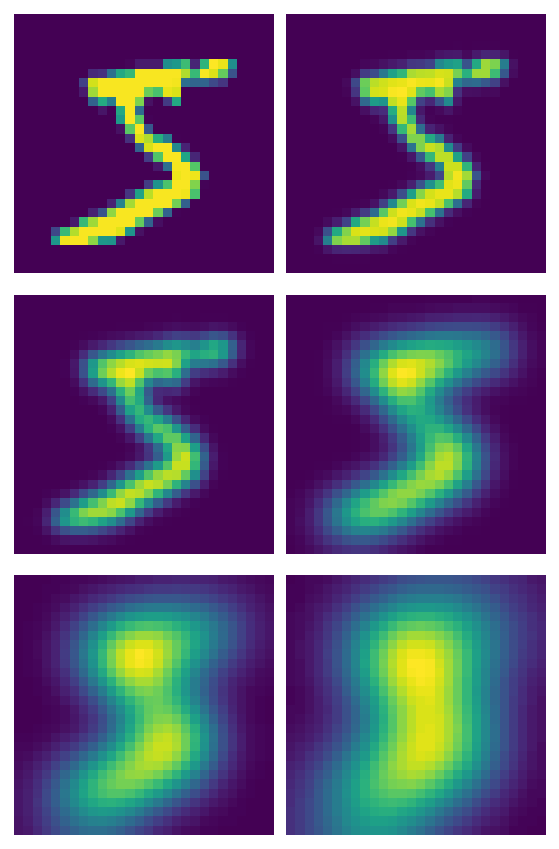

In [5]:
radii = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axi, radius in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.blur, radius=radius)
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [6]:
class BlurRad:
    def __init__(self, rad):
        self.rad = rad
        
    def __call__(self, img):
        return self.blur_multiple(img)

    def blur(self, X):
        """
        Blur an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        radius: float
            The amout of blurriness
        """
        return image.aug_np_wrapper(X, image.blur, radius=self.rad)

    def blur_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_blur = self.blur(X)
            images_out.append(img_blur)
        images_out = np.stack(images_out, axis=0)
        return images_out

In [7]:
n_processes = 90
X_train_partition = np.array_split(X_train, n_processes)

In [8]:
%%time
pool = Pool(processes=n_processes)
X_train_blur = pool.map(BlurRad(2.5), X_train_partition)
X_train_blur = np.concatenate(X_train_blur, axis=0)
print(X_train_blur.shape)
pool.close()

(60000, 28, 28)
CPU times: user 112 ms, sys: 675 ms, total: 787 ms
Wall time: 845 ms


## Estimating weights

In [9]:
def estimate_weights(model, X, y, key, optimizer, n_epochs=200, seed=None,
                     output_progress=False, print_final_loss=False):
    loss = dojax.make_mse_func(model, X, y)
    batch = jnp.ones((1, 2))
    params = model.init(key, batch)
    opt_state = optimizer.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    
    for i in range(n_epochs):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if i % 50 == 0 and output_progress:
            print('Loss step {}: '.format(i), loss_val)
    if print_final_loss:
        print(f"Final loss: {loss_val}")
        
    output = {
        "params": params,
        "final_loss": loss_val,
        "train_accuracy": (model.apply(params, X).round().ravel() == y).mean()
    }
    
    return output

In [10]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn

In [11]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn
    # return jax.jit(loss_fn) # assuming top-levelled funciton is not jitted

class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step

In [12]:
key = jax.random.PRNGKey(314)
n_classes = 10
n_subset = 5000

model = MLPWide(n_classes)
X_train_ravel = X_train.reshape(-1, 28 ** 2)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

alpha = 0.001
tx = optax.adam(learning_rate=alpha)
batch = jnp.ones((1, 28 ** 2))
params = model.init(key, batch)
opt_state = tx.init(params)

In [13]:
batch_size = 2_000
n_epochs = 100

for e in range(n_epochs):
    print(f"@epoch {e:03}", end="\r")
    params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

In [14]:
(y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean()

DeviceArray(0.99916667, dtype=float32)